# Scanning binding energy and rates parameters for adaptable circuits

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.style.use('seaborn-v0_8')
import seaborn as sns
import pandas as pd
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import jax

from bioreaction.simulation.basic_sim import basic_de_sim, convert_model, BasicSimParams, BasicSimState
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.model.data_containers import Impulse
from bioreaction.simulation.med_sim import get_int_med_model, simulate_chunk, MedSimParams, MedSimInternelState

from copy import deepcopy
import os
import sys

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)

from tests.shared import five_circuits, CONFIG

config = deepcopy(CONFIG)

In [3]:
num_species = 3
# num_boundspecies = np.math.factorial(3)
signal_species_idx = 0
a = [1, 1, 1]
d = [1, 1, 1]
ka = [4, 1, 1]
kd = [1, 1, 2]

model = construct_model_fromnames([str(i) for i in range(num_species)])
model.species


[Species: ('0', '0'),
 Species: ('0', '1'),
 Species: ('0', '2'),
 Species: ('1', '1'),
 Species: ('1', '2'),
 Species: ('2', '2'),
 Species: 0,
 Species: 1,
 Species: 2]

In [4]:

for i, r in enumerate(model.reactions):
    if not r.input: # 0 -> RNA
        model.reactions[i].forward_rate = a[model.species[-num_species:].index(r.output[0])]
        model.reactions[i].reverse_rate = 0
    elif not r.output: # RNA -> 0
        model.reactions[i].forward_rate = d[model.species[-num_species:].index(r.input[0])]
        model.reactions[i].reverse_rate = 0
    else:
        model.reactions[i].forward_rate = ka[model.species[-num_species:].index(r.input[0])]
        model.reactions[i].reverse_rate = kd[model.species[-num_species:].index(r.input[0])]

sim_model = convert_model(model)
params = BasicSimParams(delta_t=0.01, total_time=100)

In [5]:
s0 = np.concatenate([np.zeros(len(model.species[:-num_species])), [1, 1, 1]])
starting_state = BasicSimState(concentrations=s0)

state = basic_de_sim(starting_state=starting_state, model=sim_model, params=params)
results_species = np.concatenate([np.expand_dims(starting_state.concentrations, axis=0), state[1]])[:, -num_species:]
t = np.arange(params.total_time / params.delta_t) * params.delta_t


2023-03-01 17:11:44.197044: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.4 which is older than the ptxas CUDA version (12.0.140). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


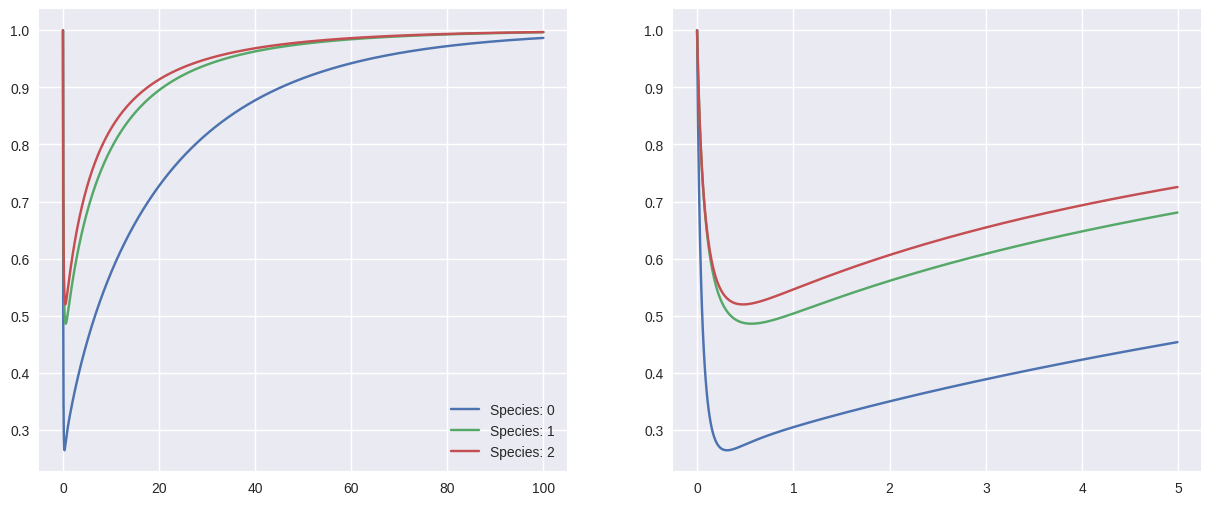

In [6]:
plt.figure(figsize=(15, 6))
ax = plt.subplot(1,2,1)
plt.plot(t, results_species)
plt.legend(model.species[-num_species:])

ax = plt.subplot(1,2,2)
till = int(5 / params.delta_t)
plt.plot(t[:till], results_species[:till, :])


## As med sim

In [7]:

import bioreaction
med_model = bioreaction.templates.generate_rnabinding_medsim(
    num_species=3,
    a=[1, 1, 1],
    d=[1, 1, 1],
    ka=np.asarray(
        [[1, 2, 1],
         [2, 1, 1],
         [1, 1, 1]]),
    kd=np.asarray(
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 3]]),
    impulse_idx=0
)


In [8]:
int_med_model = get_int_med_model(med_model)

int_med_state = MedSimInternelState(concentrations=jnp.array(starting_state.concentrations), other_factors=jnp.zeros(len(med_model.other_factors)))

# Choose how reactions are modelled. AGAIN THIS IS DUMB
# Rememer, this is PER REACTION. If you don't want to think about it,
# You can set them all to be the same and it's chill
# If both are 0, it's determinisic. If just brown is 1, it's brown
# if just poiss is 1, it's poisson. Don't ask what happens if both are 1
poiss_simmed = jnp.ones(len(med_model.reactions))
brown_simmed = jnp.zeros(len(med_model.reactions))

# Making the params for the simulation, how things are simutated and for how long.
int_med_params = MedSimParams(delta_t= 0.01, t_start=0.0, t_end = 20.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)

In [9]:
key = jr.PRNGKey(0)
# We run the plot the results.
result_1 = simulate_chunk(key, int_med_state, int_med_model, int_med_params)

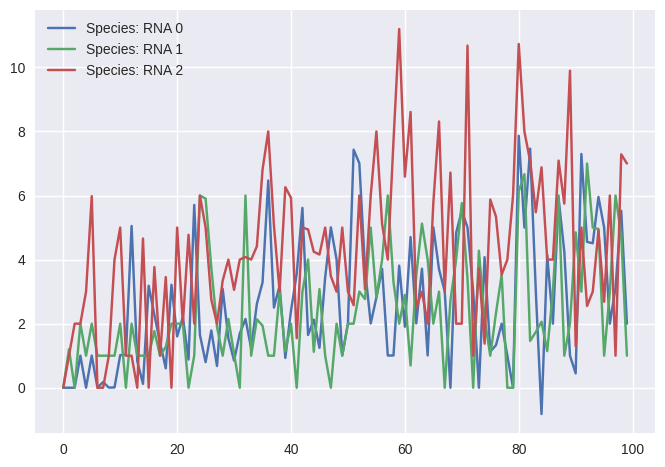

In [10]:

plt.plot(np.array(result_1.ys.concentrations)[:, :3], label=[str(s) for s in med_model.species[:3]])
plt.legend()

In [11]:
def to_vmap_1(rng):
    return simulate_chunk(rng, int_med_state, int_med_model, int_med_params)

vmap_sim1 = jax.jit(jax.vmap(to_vmap_1))

# def to_vmap_2(rng):
#     return simulate_chunk(rng, int_med_state, int_med_model_2, int_med_params)

# vmap_sim2 = jax.jit(jax.vmap(to_vmap_2))

rng_keys = jr.split(key, 100)

big_result_1 = vmap_sim1(rng_keys)

# big_result_2 = vmap_sim2(rng_keys)

In [20]:
med_model

MedModel(species=[Species: RNA 0, Species: RNA 1, Species: RNA 2, Species: RNA 0-0, Species: RNA 0-1, Species: RNA 0-2, Species: RNA 1-1, Species: RNA 1-2, Species: RNA 2-2], reactions=[Reaction(input=[], output=[Species: RNA 0], forward_rate=1, reverse_rate=0), Reaction(input=[Species: RNA 0], output=[], forward_rate=0, reverse_rate=1), Reaction(input=[], output=[Species: RNA 1], forward_rate=1, reverse_rate=0), Reaction(input=[Species: RNA 1], output=[], forward_rate=0, reverse_rate=1), Reaction(input=[], output=[Species: RNA 2], forward_rate=1, reverse_rate=0), Reaction(input=[Species: RNA 2], output=[], forward_rate=0, reverse_rate=1), Reaction(input=[Species: RNA 0, Species: RNA 0], output=[Species: RNA 0-0], forward_rate=1, reverse_rate=1), Reaction(input=[Species: RNA 0, Species: RNA 1], output=[Species: RNA 0-1], forward_rate=2, reverse_rate=1), Reaction(input=[Species: RNA 0, Species: RNA 2], output=[Species: RNA 0-2], forward_rate=1, reverse_rate=1), Reaction(input=[Species: 

In [19]:
basic_med_result = basic_de_sim(int_med_state, med_model, BasicSimParams(delta_t=int_med_params.delta_t, total_time=int_med_params.t_end))

AttributeError: 'MedModel' object has no attribute 'inputs'

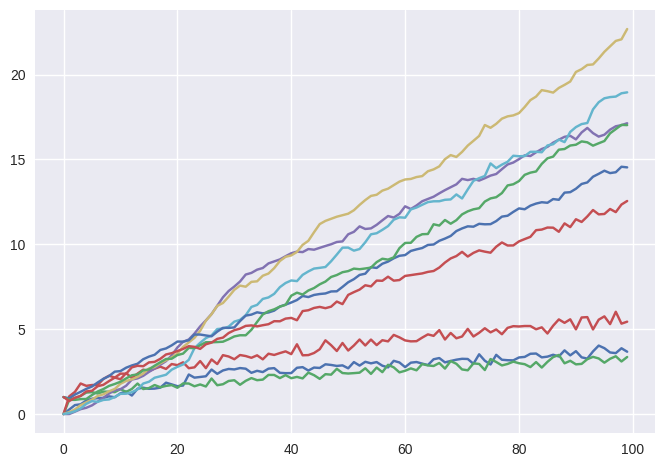

In [14]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)
plt.plot(jnp.mean(big_result_1.ys.concentrations, axis = 0))
ax = plt.subplot(1,2,1)
plt.plot()

## Adding Impulse

In [ ]:
impulse = Impulse(target=model.species[-num_species:][0], delta_target=1, time=4, impulse_width=1)
